In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from backend.ml.common import get_total_enrolment_series
from backend.common.state_resolver import resolve_state


In [2]:
from backend.db.session import DB_PATH, DATABASE_URL
print("DATABASE_URL =", DATABASE_URL)
print("DB_PATH =", DB_PATH)
print("DB exists =", DB_PATH.exists())


DATABASE_URL = sqlite:///C:\Users\grimm\Hackathon\uidai_hackathon\uidai.db
DB_PATH = C:\Users\grimm\Hackathon\uidai_hackathon\uidai.db
DB exists = True


In [3]:
state_in = "UP"   # try: UP, Bihar, Assam etc.
state = resolve_state(state_in)

series = get_total_enrolment_series(state=state)

df = pd.DataFrame(series)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")

df.tail()


,date,total_enrolment
83,2025-12-26,9933
84,2025-12-27,6982
85,2025-12-28,7902
86,2025-12-29,7360
87,2025-12-31,26655


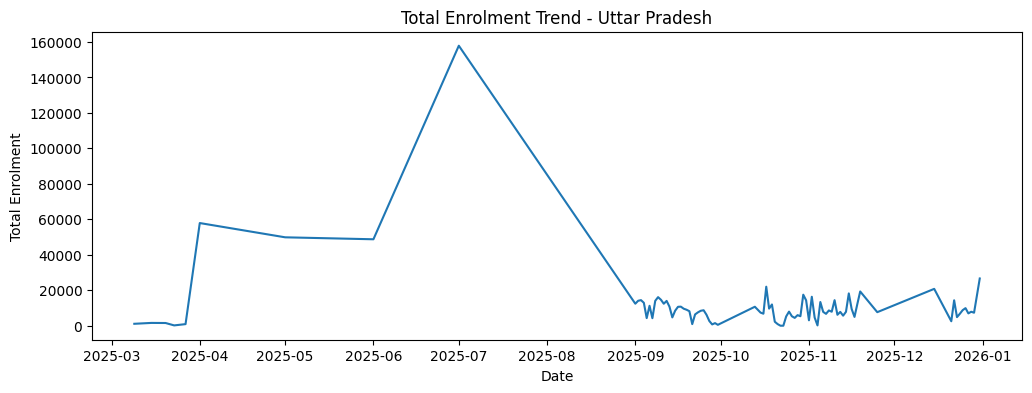

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df["date"], df["total_enrolment"])
plt.title(f"Total Enrolment Trend - {state}")
plt.xlabel("Date")
plt.ylabel("Total Enrolment")
plt.show()


In [6]:
df_feat = df.copy()

df_feat["dayofweek"] = df_feat["date"].dt.dayofweek
df_feat["month"] = df_feat["date"].dt.month
df_feat["day"] = df_feat["date"].dt.day

df_feat["lag_1"] = df_feat["total_enrolment"].shift(1)
df_feat["lag_7"] = df_feat["total_enrolment"].shift(7)

df_feat["roll_7"] = df_feat["total_enrolment"].rolling(7).mean()
df_feat["roll_14"] = df_feat["total_enrolment"].rolling(14).mean()
df_feat["roll_std_7"] = df_feat["total_enrolment"].rolling(7).std()

df_feat = df_feat.dropna()
df_feat.head()


,date,total_enrolment,dayofweek,month,day,lag_1,lag_7,roll_7,roll_14,roll_std_7
13,2025-09-05,4305,4,9,5,12947.0,49861.0,37833.285714,26999.285714,54812.963685
14,2025-09-06,11261,5,9,6,4305.0,48753.0,32477.285714,27724.142857,55396.758304
15,2025-09-07,4260,6,9,7,11261.0,157866.0,10533.571429,27913.857143,4397.051090
16,2025-09-08,14051,0,9,8,4260.0,12436.0,10764.285714,28806.642857,4553.109110
17,2025-09-09,16131,1,9,9,14051.0,14088.0,11056.142857,29944.285714,4857.006912


In [7]:
df_feat.shape, df.shape


((75, 10), (88, 2))

In [8]:
df_feat["expected_proxy"] = df_feat["roll_7"]
df_feat["gap_proxy"] = df_feat["total_enrolment"] - df_feat["expected_proxy"]

df_feat[["date", "total_enrolment", "expected_proxy", "gap_proxy"]].tail(10)


,date,total_enrolment,expected_proxy,gap_proxy
78,2025-12-21,2543,11011.428571,-8468.428571
79,2025-12-22,14345,11709.428571,2635.571429
80,2025-12-23,4867,11691.428571,-6824.428571
81,2025-12-24,6738,10897.857143,-4159.857143
82,2025-12-25,8804,9394.142857,-590.142857
83,2025-12-26,9933,9718.285714,214.714286
84,2025-12-27,6982,7744.571429,-762.571429
85,2025-12-28,7902,8510.142857,-608.142857
86,2025-12-29,7360,7512.285714,-152.285714
87,2025-12-31,26655,10624.857143,16030.142857


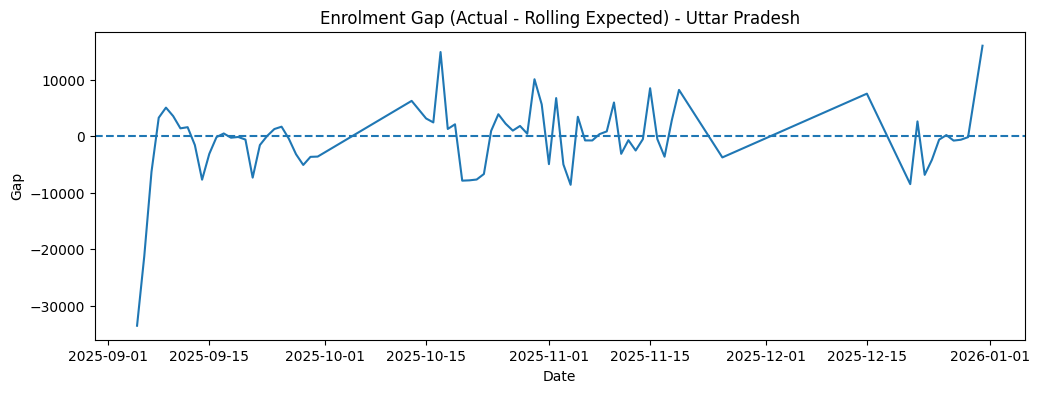

In [9]:
plt.figure(figsize=(12,4))
plt.plot(df_feat["date"], df_feat["gap_proxy"])
plt.axhline(0, linestyle="--")
plt.title(f"Enrolment Gap (Actual - Rolling Expected) - {state}")
plt.xlabel("Date")
plt.ylabel("Gap")
plt.show()
